In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt

## Random Agent 

FrozenLake is a simple text-based environment where agent starts in the top left corner and needs to make it down to the bottom right corner to retrieve his/her frisbee. The agent is on a frozen lake so it will sometimes slide in a driection it didn't intend to. The agent receives a reward of 1 for making it to the bottom right corner. Other steps have a reward of 0. The game terminates if the agent falls into a hole on the ice. https://gym.openai.com/envs/FrozenLake-v0/

This first agent is a random agent that randomly samples actions from the action space. 

In [4]:
import gym 
# instantiate the environment 
env = gym.make('FrozenLake-v0')

# initialize reward and steps 
total_reward = 0.0
total_steps = 0
# the reset method initializes the environment 
obs = env.reset()

while True:
    action = env.action_space.sample() #.sample method gives a random action sample
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    if done:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))

Episode done in 7 steps, total reward 0.00


Have the agent play a thousand games to get a sense of how this random agent performs. 

In [5]:
# instantiate the environment 
# this is adaped from the class notebook introducting the project
env = gym.make('FrozenLake-v0')


num_games = 1000 
# empty lists to keep track of win percentage and rewards
win_pct = []
rewards = []

for i in range(num_games):
    # initialize reward and steps 
    total_reward = 0.0
    total_steps = 0
    # the reset method initializes the environment 
    obs = env.reset()

    while True:
        action = env.action_space.sample() #.sample method gives a random action sample
        # get updated obs, reward, done, info, by
        # stepping through the environment
        obs, reward, done, _ = env.step(action)
        # keep running sum of rewards and steps 
        total_reward += reward
        total_steps += 1
        if done:
            break
    # at the end of every episode
    # append score for that episode to list of rewards
    rewards.append(total_reward)
    # keep running average of the win percentage for the past 10 games 
    if i % 10 == 0:
        average = np.mean(rewards[-10:])
        win_pct.append(average)

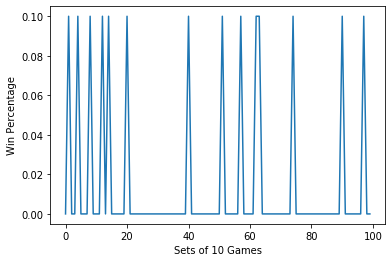

In [6]:
# plot win percentage over the trailing 10 games 
plt.plot(win_pct)
plt.xlabel("Sets of 10 Games")
plt.ylabel("Win Percentage")
plt.show()

As expected, the random agent does not perform well. The above plot of win percentage shows that the trailing average of win percentage for the past 10 games is never over 10%. 

## Deterministic Policy 

In [7]:
# instantiate the environment 
env = gym.make('FrozenLake-v0')
"""
Here is what the maze for FrozenLake looks like:
S: starting point, safe
F: frozen surface, safe
H: hole, fall to your doom
G: goal, where the frisbee is located

SFFF
FHFH
FFFH
HFFG

For actions:
Left = 0,
Down = 1,
Right = 2,
Up = 3 
"""

num_games = 1000 
# empty lists to keep track of win percentage and rewards
win_pct = []
rewards = []

# use a dictionary to represent policy 
# keys correspond to states, 
# values correspond to actions
# choose policy based on Manhattan Distance to goal 
policy = {0: 1, 1: 2, 2: 1, 3: 0, 4: 1, 6: 1, 8: 2, 9: 1, 10: 1, 13: 2, 14: 2} 
for i in range(num_games):
    # initialize reward and steps 
    total_reward = 0.0
    total_steps = 0
    # the reset method initializes the environment 
    obs = env.reset()

    while True:
        # look up the policy for that state 
        action = policy[obs]
        # get updated obs, reward, done, info, by
        # stepping through the environment
        obs, reward, done, _ = env.step(action)
        # keep running sum of rewards and steps 
        total_reward += reward
        total_steps += 1
        if done:
            break
    # at the end of every episode
    # append score for that episode to list of rewards
    rewards.append(total_reward)
    # keep running average of the win percentage for the past 10 games 
    if i % 10 == 0:
        average = np.mean(rewards[-10:])
        win_pct.append(average)

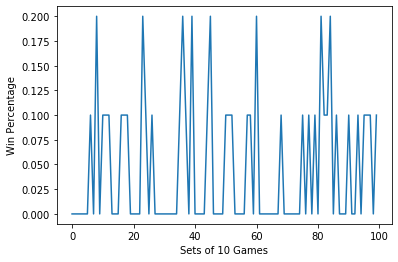

In [8]:
# plot win percentage over the trailing 10 games 
plt.plot(win_pct)
plt.xlabel("Sets of 10 Games")
plt.ylabel("Win Percentage")
plt.show()

Now the win percentage has improved to 20%, and we hit this a few times throughout the course of playing. The performance of this deterministic agent is better than the random agent, but it still doesn't win often. 

## Q Learning: On Policy Active Reinforcement Learning with Temporal Difference Control 
**Temporal Difference** is a running moving average. 
FrozenLake has a small number of states and actions. It is possible to represent state, action pairs as a table where columns are actions and states are rows. A **tabular learning method** uses a table to keep track of the states and actions an agent has visited. <br> 
We can use **Epsilon Greedy** action selection: for a given state (s) look up Q for each action (a). Most of the time, we take the **max action**, but sometimes we take a random action. <br>
Use the reward received to update Q for s,a. <br>
This is an **off policy learning method.** (an alternative on policy strategy would be SARSA.) 

In [12]:
# this agent class is adapted from the class notebook 
#deterministic rule
# first choose random action
# monitor vc and vp while keep going to the same direction
# if the sign of the two velocities are different, flip the direction (action)
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Agent:
    def __init__(self, alpha, gamma, epsilon, epsilon_min, epsilon_dec_rate):
        #self.env = gym.make("CartPole-v0")
        self.env = gym.make('FrozenLake-v0')
        self.state = self.env.reset()
        # FrozenLake is a 4 x 4 grid 
        self.num_states = 16
        # actions are: Left, Right, Up, Down
        self.num_actions = 4
        
        #self.state = self.env.reset()
        self.rewards = []
        self.steps = []
        self.win_pct_lst = []
        self.policy = []
        # save alpha, gamma, and epsilon as member variables of class
        self.alpha = alpha
        self.gamma = gamma
        """
        It is important that epsilon decreases over time.
        The agent starts out doing a higher rate of exploration.
        As the agent learns more, the agent exploits high reward actions
        and decreass he rate of exploration. 
        """
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        # rate at which epsilon decreases 
        self.epsilon_dec_rate = epsilon_dec_rate
        # use a dictionary for Q 
        self.Q = {}
        # initialize Q for all states s and actions a 
        self.init_Q()
    
    
    def init_Q(self):
        """
        start by initializing the Q-value for each (state, action) pair to 0
        TODO: check code for Berkeley dictionary with default 0 values 
        """
        for state in range(self.num_states):
            for action in range(self.num_actions):
                self.Q[(state, action)] = 0.0 
        
        
    def select_action(self, state):  
        # we are using an epsilon greedy strategy to select actions
        # random.random() returns a number between 0.0 and 1.0 
        # https://stackoverflow.com/questions/33359740/random-number-between-0-and-1-in-python
        if random.random() < self.epsilon:
            # select a random action 
            action = random.randint(0, self.num_actions-1)
        else: 
            # https://www.geeksforgeeks.org/range-to-a-list-in-python/
            actions = [*range(self.num_actions)]
            """
            create a list of q_values for each possible action from a state 
            the index of each value in the q_values list corresponds to the action
            to return the index of the max value in a list, this Stack Oveflow post
            advises using NumPy beause of its argmax operator: 
            https://stackoverflow.com/questions/2474015/getting-the-index-of-the-returned-max-or-min-item-using-max-min-on-a-list
            """
            q_values = np.array([self.Q[(state, action)] for action in actions])
            # in tiebreaking scenarios, argmax returns the index of the first max value
            # TODO: could randomly select index in the event of ties 
            action = np.argmax(q_values)
            
        return action
    
    def decay_epsilon(self):
        """
        TODO: look at other strategies for this 
        One source on Exploration/Exploitation Trade-off: 
        https://www.manifold.ai/exploration-vs-exploitation-in-reinforcement-learning
        References the Decaying Epsilon Greedy Algorithm 
        Review algorithm options
        """
        if self.epsilon > self.epsilon_min:
            # TODO: currently this is a linear dependence
            # you could also use a 1/square root dependence, or an exponential or logarithmic dependence
            # isn't really critical 
            # do need to make sure it reduces epsilon to min epsilon value over time 
            self.epsilon = self.epsilon*self.epsilon_dec_rate 
        else:
            self.epsilon = self.epsilon_min 
    
    def update_Qval(self, state, action, reward, successor_state):
        actions = [*range(self.num_actions)]
        succ_qVals = np.array([self.Q[(successor_state, action)] for action in actions])
        # in tiebreaking scenarios, argmax returns the index of the first max value
        # TODO: could randomly select index in the event of ties 
        best_action = np.argmax(succ_qVals)
        # Q value update function 
        # TODO: review this 
        self.Q[(state, action)] += self.alpha*(reward + self.gamma*self.Q[(successor_state, best_action)]\
                                               - self.Q[(state, action)])
        # decay epsilon 
        self.decay_epsilon()

    def play_episode(self, env):
        total_reward = 0.0
        state = env.reset()
        action = random.choice([0,1])
        steps = 0
        actions = []
        while True:
            # calls the select_action function
            # which is following an epsilon greedy approach
            action = self.select_action(state)
            new_state, reward, is_done, _ = env.step(action)
            # add this in 
            self.update_Qval(state, action, reward, new_state)
            total_reward += reward
            steps +=1
            actions.append(action)
            if is_done:
                break
            state = new_state
        return total_reward, steps, actions
    
    def repeat(self,n_sample):
        rewards =[]
        steps=[]
        win_pct_lst = []
        policy = []
        for i in range(n_sample):
            reward, step, actions = self.play_episode(self.env)
            rewards.append(reward)
            steps.append(step)
            policy.append(actions)
            if i % 100 == 0:
                win_pct = np.mean(rewards[-100:])
                win_pct_lst.append(win_pct)
            if i % 1000 == 0:
                print('episode', i, 'win %.2f' % win_pct, 
                     'epsilon %.2f' % agent.epsilon)
        self.rewards = rewards
        self.steps = steps
        self.win_pct_lst = win_pct_lst
        self.policy = np.array(policy)
        plt.plot(win_pct_lst)
        plt.title("Win Percentage Over the Past 100 Games")
        plt.ylabel("Win Percentage")
        plt.show()
        

episode 0 win 0.00 epsilon 1.00
episode 1000 win 0.00 epsilon 1.00
episode 2000 win 0.03 epsilon 0.99
episode 3000 win 0.00 epsilon 0.99
episode 4000 win 0.05 epsilon 0.98
episode 5000 win 0.00 epsilon 0.98
episode 6000 win 0.00 epsilon 0.98
episode 7000 win 0.04 epsilon 0.97
episode 8000 win 0.03 epsilon 0.97
episode 9000 win 0.01 epsilon 0.97
episode 10000 win 0.02 epsilon 0.96
episode 11000 win 0.01 epsilon 0.96
episode 12000 win 0.02 epsilon 0.96
episode 13000 win 0.01 epsilon 0.95
episode 14000 win 0.03 epsilon 0.95
episode 15000 win 0.02 epsilon 0.94
episode 16000 win 0.02 epsilon 0.94
episode 17000 win 0.00 epsilon 0.94
episode 18000 win 0.01 epsilon 0.93
episode 19000 win 0.02 epsilon 0.93
episode 20000 win 0.01 epsilon 0.93
episode 21000 win 0.02 epsilon 0.92
episode 22000 win 0.04 epsilon 0.92
episode 23000 win 0.02 epsilon 0.91
episode 24000 win 0.00 epsilon 0.91
episode 25000 win 0.06 epsilon 0.91
episode 26000 win 0.01 epsilon 0.90
episode 27000 win 0.01 epsilon 0.90
episo

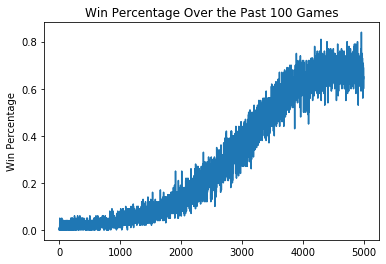

In [13]:
agent = Agent(alpha=0.001, gamma=0.9, epsilon=1.0, epsilon_min=0.01, epsilon_dec_rate=0.9999995)
agent.repeat(500000)

The Agent either receives a score of 1.0 for winning or 0.0 for falling into a hole. This histogram isn't all that helpful in this case. We can see that the agent loses more games than the agent wins. The win percentage graph above is more useful for demonstrating that the agent learns over time. 

0.301848 0.45905967465679237 1.0


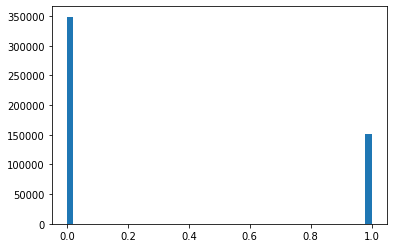

In [14]:
rewards = agent.rewards
plt.hist(rewards,bins=50)
print(np.mean(rewards), np.std(rewards), max(rewards))